In [1]:
!pip install torch torchvision transformers opencv-python scikit-learn thop

In [2]:
import pandas as pd

# Load the CSV file
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTyh006zrmSWoKAwqF92kZ4lvNRKsZL5NYIkdSEK3wtrWA8yMKLT6K3h1k1nyyHjG9ntZvc9tTcbUif/pub?output=csv'
df = pd.read_csv(url,encoding="utf-8")
df.head()


,id,caption,label,level,area,Unnamed: 5
0,1,গোমতী নদীর পানি উত্তর পাশে পালপাড়া অংশে বাঁধ থ...,flood,1.0,NaN,NaN
1,2,গোমতী নদীর পানি উত্তর পাশে পালপাড়া অংশে বাঁধ থ...,flood,1.0,NaN,NaN
2,3,কুমিল্লা,flood,1.0,কুমিল্লা,NaN
3,4,আখাউড়া উপজেলা ও কসবা উপজেলা'র বিভিন্ন এলাকায় ই...,flood,1.0,আখাউড়া,NaN
4,5,ফেনীর মুহুরী নদীতে পানির মাত্রা গত ৪০ বছরের ইত...,flood,1.0,ফেনী,NaN


In [3]:
# Verify column names
print(df.columns)

Index([' id', 'caption', 'label', 'level', 'area', 'Unnamed: 5'], dtype='object')


In [4]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from torchvision import transforms, models
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
from thop import profile
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [5]:
# Drop unnecessary columns if they exist
columns_to_drop = [col for col in ['level', 'area', 'Unnamed: 5'] if col in df.columns]
df = df.drop(columns_to_drop, axis=1)

# Shuffle the dataframe
df = shuffle(df, random_state=42)

In [6]:
df.head()

,id,caption,label
1057,1058,পাইলটের শেষ মুহূর্তের প্রচেষ্টা সত্ত্বেও দুর্ঘ...,Anthropogenic
5868,5869,প্যাডেল এক্সারসাইজার মিনি এক্সারসাইজ বাইক আর্ম...,Non Informative
4195,4196,দেশাল ব্লাউজ কালেকশনে প্রতিটি ব্লাউজে রয়েছে হা...,Non Informative
4837,4838,খিচুড়ি - হাস ভুনা - আমের আচার 🌻🌻,Non Informative
4354,4355,কালকে ওরে সোফার রুমে ঘুমে রেখে এসে আমি বেডরুমে...,Non Informative


In [7]:
# Define label mapping
label_mapping = {
    'flood': 0,
    'Cyclone': 1,
    'Earthquake': 2,
    'River Erosion': 3,
    'Fire' : 4,
    'Anthropogenic': 5,
    'Non Informative': -1  # Will be filtered out
}

# Apply label mapping and remove 'Non Informative' rows
df['label'] = df['label'].map(label_mapping)
df = df[df['label'] != -1].reset_index(drop=True)

In [8]:
# Split the dataset
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

train_data, val_test = train_test_split(df, train_size=train_ratio, random_state=42)
valid_data, test_data = train_test_split(val_test, train_size=val_ratio / (val_ratio + test_ratio), random_state=42)

In [9]:
train_data.columns = train_data.columns.str.strip()
valid_data.columns = valid_data.columns.str.strip()
test_data.columns = test_data.columns.str.strip()


In [10]:
# Define the transformations for the images
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')



tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [11]:
# Custom Dataset
class MultimodalDataset(Dataset):
    def __init__(self, dataframe, images_folder, tokenizer, image_transforms):
        self.dataframe = dataframe
        self.images_folder = images_folder
        self.tokenizer = tokenizer
        self.image_transforms = image_transforms
        self.class_to_index = {
            'flood': 0,
            'cyclone': 1,
            'earthquake': 2,
            'river erosion': 3,
            'fire': 4,
            'anthropogenic': 5
        }
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        text = str(row['caption'])
        label = int(row['label'])
        image_id = str(row['id']).strip()

        image_path = os.path.join(self.images_folder, f"{image_id}.jpg")
        if not os.path.exists(image_path):
            image_path = os.path.join(self.images_folder, f"{image_id}.png")
        if not os.path.exists(image_path):
            image_path = os.path.join(self.images_folder, f"{image_id}.jpeg")
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image {image_id} not found")

        image = Image.open(image_path).convert('RGB')
        image = self.image_transforms(image)
        text_inputs = self.tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=128)

        assert 0 <= label <= 5, f"Label {label} out of range"

        return {
            'input_ids': text_inputs['input_ids'].squeeze(),
            'attention_mask': text_inputs['attention_mask'].squeeze(),
            'image': image,
            'label': torch.tensor(label, dtype=torch.long),
            'original_label': self.index_to_class[label]
        }

In [12]:
# Create datasets and dataloaders
images_folder = '/kaggle/input/mddb-images/Photos_Final'
train_dataset = MultimodalDataset(train_data, images_folder, tokenizer, image_transforms)
valid_dataset = MultimodalDataset(valid_data, images_folder, tokenizer, image_transforms)
test_dataset = MultimodalDataset(test_data, images_folder, tokenizer, image_transforms)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [13]:

print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

1899
633
634


In [14]:
# Define the late fusion model
class LateFusionModel(nn.Module):
    def __init__(self, num_classes=6, bert_model_name='bert-base-multilingual-cased', efficientnet_model='efficientnet_b0'):
        super(LateFusionModel, self).__init__()
        
        # Text branch: BanglaBERT
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.text_fc = nn.Sequential(
            nn.Linear(768, 256),  # BERT output size is 768
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128)   # Reduce to a smaller feature size
        )
        
        # Image branch: EfficientNet
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        in_features = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Identity()  # Remove original classifier
        self.image_fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128)   # Reduce to a smaller feature size
        )
        
        # Fusion layer: Concatenate text and image features
        self.fusion_fc = nn.Sequential(
            nn.Linear(128 + 128, 64),  # Concatenated size: 128 (text) + 128 (image)
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)  # Final classification layer
        )
        
    def forward(self, input_ids, attention_mask, image):
        # Text branch
        text_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_outputs.pooler_output  # [CLS] token embedding
        text_features = self.text_fc(text_features)  # Process text features
        
        # Image branch
        image_features = self.efficientnet(image)  # Extract image features
        image_features = self.image_fc(image_features)  # Process image features
        
        # Late fusion: Concatenate features
        fused_features = torch.cat((text_features, image_features), dim=1)
        output = self.fusion_fc(fused_features)  # Final classification
        
        return output

In [15]:
# Initialize model, loss, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LateFusionModel(num_classes=6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5, weight_decay=1e-4)
scaler = GradScaler()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True)

# Training loop
num_epochs = 10
train_losses = []
valid_losses = []
best_valid_loss = float('inf')
best_model_path = 'best_model.pth'

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * input_ids.size(0)

    train_loss /= len(train_dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for batch in valid_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * input_ids.size(0)

    valid_loss /= len(valid_dataset)
    valid_losses.append(valid_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")
    scheduler.step(valid_loss)
    # Save best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), best_model_path)

# Load best model for evaluation
model.load_state_dict(torch.load(best_model_path))
# model.eval()

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 142MB/s] 
<ipython-input-15-bb783eaa5b8a>:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', 

Epoch 1/10, Train Loss: 1.7532, Valid Loss: 1.6181


Epoch 2/10: 100%|██████████| 119/119 [01:14<00:00,  1.60it/s]


Epoch 2/10, Train Loss: 1.3384, Valid Loss: 0.9568


Epoch 3/10: 100%|██████████| 119/119 [01:18<00:00,  1.51it/s]


Epoch 3/10, Train Loss: 0.7470, Valid Loss: 0.6272


Epoch 4/10: 100%|██████████| 119/119 [01:18<00:00,  1.51it/s]


Epoch 4/10, Train Loss: 0.4304, Valid Loss: 0.3408


Epoch 5/10: 100%|██████████| 119/119 [01:18<00:00,  1.51it/s]


Epoch 5/10, Train Loss: 0.2957, Valid Loss: 0.3478


Epoch 6/10: 100%|██████████| 119/119 [01:18<00:00,  1.51it/s]


Epoch 6/10, Train Loss: 0.2363, Valid Loss: 0.2698


Epoch 7/10: 100%|██████████| 119/119 [01:18<00:00,  1.52it/s]


Epoch 7/10, Train Loss: 0.1778, Valid Loss: 0.2592


Epoch 8/10: 100%|██████████| 119/119 [01:18<00:00,  1.51it/s]


Epoch 8/10, Train Loss: 0.1507, Valid Loss: 0.3237


Epoch 9/10: 100%|██████████| 119/119 [01:18<00:00,  1.52it/s]


Epoch 9/10, Train Loss: 0.1658, Valid Loss: 0.2406


Epoch 10/10: 100%|██████████| 119/119 [01:18<00:00,  1.52it/s]


Epoch 10/10, Train Loss: 0.0943, Valid Loss: 0.2944


<ipython-input-15-bb783eaa5b8a>:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


<All keys matched successfully>


Test Set Evaluation:
Accuracy: 0.9290
Precision: 0.9310
Recall: 0.9290
F1 Score: 0.9293

Classification Report:
               precision    recall  f1-score   support

        flood       0.94      0.89      0.91       114
      cyclone       0.84      0.94      0.89        93
   earthquake       0.91      0.95      0.93        84
river erosion       0.91      0.88      0.89       101
         fire       0.97      0.99      0.98       112
anthropogenic       0.98      0.92      0.95       130

     accuracy                           0.93       634
    macro avg       0.93      0.93      0.93       634
 weighted avg       0.93      0.93      0.93       634



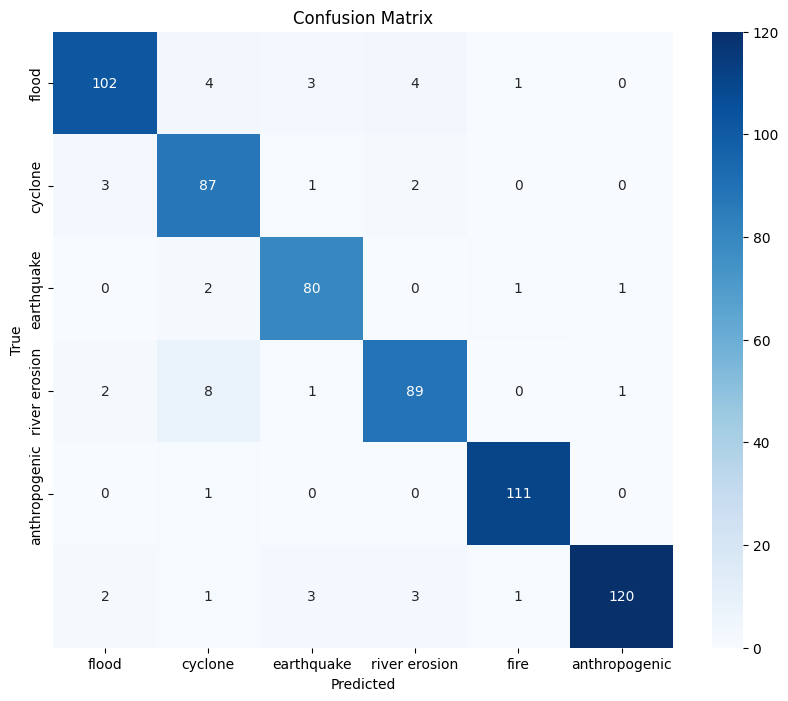

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Evaluation on test set
true_labels = []
pred_labels = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask, images)
        _, preds = torch.max(outputs, dim=1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Compute metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='weighted')
recall = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')

print("\nTest Set Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=['flood', 'cyclone', 'earthquake', 'river erosion','fire', 'anthropogenic']))

# Plot confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['flood', 'cyclone', 'earthquake', 'river erosion','fire', 'anthropogenic'], yticklabels=['flood', 'cyclone', 'earthquake', 'river erosion', 'anthropogenic'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

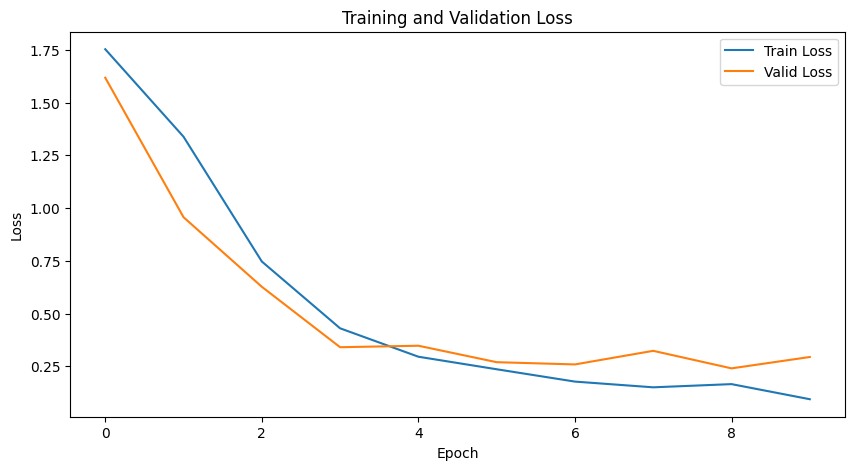

In [17]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [18]:
# Profile the model
dummy_input_ids = torch.randint(0, 1000, (1, 128)).to(device)
dummy_attention_mask = torch.ones(1, 128).to(device)
dummy_image = torch.randn(1, 3, 224, 224).to(device)
flops, params = profile(model, inputs=(dummy_input_ids, dummy_attention_mask, dummy_image))
print(f"FLOPs: {flops:.2e}, Parameters: {params:.2e}")

[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
FLOPs: 1.13e+10, Parameters: 9.03e+07
